# PHE SEIR Model Sensitivity Analysis

In this notebook we present how to use the `epimodels` module to set up a parameter sensitivity analysis of the model built by Public Health England in collaboration with University of Cambridge, using baseline contact matrices. We aim to explore the behaviour of the output of the model for changes in key parameters. This is done to identify those parameters we can infer in the model.

The analyses are run for:
 - Dates: **15 Feb 2020** - **15 May 2020**, using toy data;
 - PHE regions of interest: **London**.

We use synthetically generated serology and mortality data from simulated model.

*The Roche model is built by F. Hoffmann-La Roche Ltd.*

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

## Model Setup
### Define setup matrices for the Roche Model

In [2]:
# Populate the model
total_days =  90
regions = ['London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
# Initial state of the system
for w in weeks:
    weeks_matrices_region = []
    for r in regions:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
        regional = em.RegionMatrix(r, age_groups, region_data_matrix)
        weeks_matrices_region.append(regional)

    matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# # Initial state of the system
# weeks_matrices_region = []
# for r in regions:
#     path = os.path.join('../../data/final_contact_matrices/BASE.csv')
#     region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#     regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#     weeks_matrices_region.append(regional)

# matrices_region.append(weeks_matrices_region)

# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]

# # Matrices contact
# time_changes_contact = [1]
# time_changes_region = [1]

# NPIs data
max_levels_npi = [3, 3, 2, 4, 2, 3, 2, 4, 2]
targeted_npi = [True, True, True, True, True, True, True, False, True]
general_npi = [
    [True, False, True, True, False, False, False, False, False],
    [True, False, True, True, True, True, False, False, False]]
time_changes_flag = [1, 12]

reg_levels_npi = [
    [[0, 0, 0, 0, 0, 0, 0, 0, 0], [3, 3, 2, 4, 2, 3, 2, 4, 2]]]
time_changes_npi = [1, 14]

### Set the parameters and initial conditions of the model and bundle everything together

In [3]:
# Instantiate model
model = em.PheSEIRModel()

# Set the region names, age groups, contact and regional data of the model
model.set_regions(regions)
model.set_age_groups(age_groups)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

# Initial number of susceptibles
path = os.path.join('../../data/england_population/England_population.csv')
total_susceptibles = np.loadtxt(path, dtype=int, delimiter=',').tolist()
susceptibles = total_susceptibles[-1]

# Initial number of infectives
ICs_multiplier = 30
infectives1 = (ICs_multiplier * np.ones((len(regions), len(age_groups)))).tolist()

infectives2 = np.zeros((len(regions), len(age_groups))).tolist()

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# List of betas
LEN = len(np.arange(44, len(times), 7))
params = [0.52, 0.34, 0.34, 0.34, 0.43, 0.49, 0.49, 0.49, 0.48, 0.47, 0.48, 0.50, 0.52, 0.54]
betas = np.ones((len(regions), total_days))
for r in range(len(regions)):
    for d, day in enumerate(np.arange(44, len(times), 7)):
        betas[r, day:(day+7)] = params[r*LEN+d+1]

In [4]:
# Set regional and time dependent parameters
regional_parameters = em.PheRegParameters(
    model=model,
    initial_r=[2.35],
    region_index=1,
    betas=np.ones((len(regions), len(times))).tolist(),
    times=times
)

# Set ICs parameters
ICs = em.PheICs(
    model=model,
    susceptibles_IC=[susceptibles],
    exposed1_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    exposed2_IC=np.zeros((len(regions), len(age_groups))).tolist(),
    infectives1_IC=infectives1,
    infectives2_IC=infectives2,
    recovered_IC=np.zeros((len(regions), len(age_groups))).tolist()
)

# Set disease-specific parameters
disease_parameters = em.PheDiseaseParameters(
    model=model,
    dL=4,
    dI=4
)

# Set other simulation parameters
simulation_parameters = em.PheSimParameters(
    model=model,
    delta_t=0.5,
    method='RK45'
)

# Set all parameters in the controller
parameters = em.PheParametersController(
    model=model,
    regional_parameters=regional_parameters,
    ICs=ICs,
    disease_parameters=disease_parameters,
    simulation_parameters=simulation_parameters
)

## Death and Serology data
### Read Death and Serology data

In [5]:
# Read in synthetic death, tests and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))


In [6]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(1, total_days+1, 1).tolist()
serology_times = np.arange(1, total_days+1, 1).tolist()

In [7]:
# Set time-to-death using a Gamma distribution using the mean and standard deviation from the PHE paper
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95

## Sensitivity Analysis
### Observe changes in number of **new infections** and **deaths** for different ranges of parameters

In [8]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

### 1. Varying _Initial R_

In [9]:
# Slider (initial_r)
titles = ['Infections', 'Deaths']
fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Add traces, one for each slider step
initial_r_range = np.arange(0.3, 5, 0.05)

for initial_r in initial_r_range:
    parameters.regional_parameters.initial_r = initial_r
    model_output = model.simulate(parameters)

    model_reg_deaths_data = np.empty(len(times))

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec = np.array(model_reg_new_infections)
    predicted_deaths = model_reg_deaths_data
    
    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_new_infec,
            name='Infections'
        ),
        row= 1,
        col= 1)

    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_deaths,
            name='Deaths'
        ),
        row= 2,
        col= 1)

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(int(len(fig.data)/2)):
    step = dict(
        method="restyle",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to initial_r: " + "{:.4f}".format(initial_r_range[i])}],  # layout attribute
        label = "{:.4f}".format(initial_r_range[i])
    )
    step["args"][0]["visible"][2 * i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][1 + 2 * i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Initial_r: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black')
)

fig.show()

In [10]:
# Slider (initial_r)
titles = ['Infections', 'Deaths']
fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Add traces, one for each slider step
initial_r_range = [2.3, 3.28, 4]
traces = ['Initial R = {}'.format(r) for r in initial_r_range]

for r, initial_r in enumerate(initial_r_range):
    parameters.regional_parameters.initial_r = initial_r
    model_output = model.simulate(parameters)

    model_reg_deaths_data = np.empty(len(times))

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec = np.array(model_reg_new_infections)
    predicted_deaths = model_reg_deaths_data
    
    fig.add_trace(
        go.Scatter(
            x=times,
            y=predicted_new_infec,
            mode='lines',
            name=traces[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1)

    fig.add_trace(
        go.Scatter(
            x=times,
            y=predicted_deaths,
            mode='lines',
            showlegend=False,
            name=traces[r],
            line_color=colours[r]
        ),
        row= 2,
        col= 1)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
)

fig.write_image('images/Phe_Sensitivity_R0.pdf')
fig.show()

### 2. Varying _sigma beta_

In [10]:
parameters.regional_parameters.initial_r = [3.28]

# Slider (beta_max)
titles = ['Infections', 'Deaths']
fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Add traces, one for each slider step
sigma_b_range = []

for beta_max in beta_max_range:
    betas = np.array(parameters.regional_parameters.betas)
        for r in range(len(regions)):
            for d, day in enumerate(np.arange(44, len(times), 7)):
                betas[r, day:(day+7)] = params[r*LEN+d+1]

    parameters.regional_parameters.betas = betas.tolist()
    
    model_output = model.simulate(parameters)

    model_reg_deaths_data = np.empty(len(times))

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec = np.array(model_reg_new_infections)
    predicted_deaths = model_reg_deaths_data
    
    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_new_infec,
            name='Infections'
        ),
        row= 1,
        col= 1)

    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_deaths,
            name='Deaths'
        ),
        row= 2,
        col= 1)

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(int(len(fig.data)/2)):
    step = dict(
        method="restyle",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to sigma_b: " + "{:.4f}".format(parameters.transmission_parameters.beta_min + beta_min_range[i])}],  # layout attribute
        label = "{:.4f}".format(parameters.transmission_parameters.beta_min + beta_min_range[i])
    )
    step["args"][0]["visible"][2 * i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][1 + 2 * i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Beta_max: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black')
)

fig.show()

### 3. Varying _bss_

In [11]:
parameters.transmission_parameters = em.RocheTransmission(
    model=model,
    beta_min=0.228,
    beta_max=0.927,
    bss=3.11,
    gamma=1,
    s50=35.3
)

# Slider (bss)
titles = ['Infections', 'Deaths']
fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Add traces, one for each slider step
bss_range = np.arange(0.1, 4, 0.05 )

for bss in bss_range:
    parameters.transmission_parameters.bss = bss
    model_output = model.simulate(parameters)

    model_reg_deaths_data = np.empty(len(times))

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec = np.array(model_reg_new_infections)
    predicted_deaths = model_reg_deaths_data
    
    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_new_infec,
            name='Infections'
        ),
        row= 1,
        col= 1)

    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_deaths,
            name='Deaths'
        ),
        row= 2,
        col= 1)

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(int(len(fig.data)/2)):
    step = dict(
        method="restyle",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to gamma: " + "{:.4f}".format(bss_range[i])}],  # layout attribute
        label = "{:.4f}".format(bss_range[i])
    )
    step["args"][0]["visible"][2 * i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][1 + 2 * i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Bss: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black')
)

fig.show()

### 4. Varying _gamma_

In [12]:
parameters.transmission_parameters = em.RocheTransmission(
    model=model,
    beta_min=0.228,
    beta_max=0.927,
    bss=3.11,
    gamma=1,
    s50=35.3
)

# Slider (gamma)
titles = ['Infections', 'Deaths']
fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Add traces, one for each slider step
gamma_range = np.arange(0.1, 1, 0.01)

for gamma in gamma_range:
    parameters.transmission_parameters.gamma = gamma
    model_output = model.simulate(parameters)

    model_reg_deaths_data = np.empty(len(times))

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec = np.array(model_reg_new_infections)
    predicted_deaths = model_reg_deaths_data
    
    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_new_infec,
            name='Infections'
        ),
        row= 1,
        col= 1)

    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_deaths,
            name='Deaths'
        ),
        row= 2,
        col= 1)

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(int(len(fig.data)/2)):
    step = dict(
        method="restyle",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to gamma: " + "{:.4f}".format(gamma_range[i])}],  # layout attribute
        label = "{:.4f}".format(gamma_range[i])
    )
    step["args"][0]["visible"][2 * i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][1 + 2 * i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "Gamma: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black')
)

fig.show()

### 5. Varying _s50_

In [13]:
parameters.transmission_parameters = em.RocheTransmission(
    model=model,
    beta_min=0.228,
    beta_max=0.927,
    bss=3.11,
    gamma=1,
    s50=35.3
)

# Slider (gamma)
titles = ['Infections', 'Deaths']
fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Add traces, one for each slider step
s50_range = np.arange(5, 95, 1)

for s50 in s50_range:
    parameters.transmission_parameters.s50 = s50
    model_output = model.simulate(parameters)

    model_reg_deaths_data = np.empty(len(times))

    age_model_reg_new_infections = model.new_infections(model_output)
    model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

    for t, time in enumerate(times):
        model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))
    
    predicted_new_infec = np.array(model_reg_new_infections)
    predicted_deaths = model_reg_deaths_data
    
    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_new_infec,
            name='Infections'
        ),
        row= 1,
        col= 1)

    fig.add_trace(
        go.Bar(
            x=times,
            y=predicted_deaths,
            name='Deaths'
        ),
        row= 2,
        col= 1)

# Make 10th trace visible
fig.data[10].visible = True

# Create and add slider
steps = []
for i in range(int(len(fig.data)/2)):
    step = dict(
        method="restyle",
        args=[{"visible": [False] * len(fig.data)},
              {"title": "Slider switched to s50: " + str(s50_range[i])}],  # layout attribute
        label = str(s50_range[i])
    )
    step["args"][0]["visible"][2 * i] = True  # Toggle i'th trace to "visible"
    step["args"][0]["visible"][1 + 2 * i] = True  # Toggle i'th trace to "visible"
    steps.append(step)

sliders = [dict(
    active=10,
    currentvalue={"prefix": "S50: "},
    pad={"t": 50},
    steps=steps
)]

fig.update_layout(
    sliders=sliders
)

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, total_days, 10).tolist(),
        ticktext=['Feb 15', 'Feb 25', 'Mar 06', 'Mar 16', 'Mar 26', 'Apr 05', 'Apr 15', 'Apr 25', 'May 05', 'May 15', 'May 25', 'Jun 04', 'Jun 14', 'Jun 24']),
    yaxis2=dict(linecolor='black')
)

fig.show()

## Log-likelihood for beta_max & beta_min varying

In [14]:
# Initialise inference for the model
roche_inference = em.inference.RocheSEIRInfer(model)

# Add model, death, tests and NPIs data to the inference structure
roche_inference.read_model_data(susceptibles, infectives)
roche_inference.read_deaths_data(deaths_data, deaths_times, time_to_death, fatality_ratio)
roche_inference.read_serology_data(tests, positives_data, serology_times, sens, spec)
roche_inference.read_npis_data(max_levels_npi, targeted_npi, general_npi, reg_levels_npi, time_changes_npi, time_changes_flag)

In [15]:
import matplotlib
from matplotlib import pyplot as plt

In [16]:
loglik_arr = np.empty((25,25))

for ind_beta_min, beta_min in enumerate(np.linspace(0.2, 0.9, 25)):
    for ind_beta_max, beta_max in enumerate(np.linspace(0.4, 1.2, 25)):
        loglik_arr[ind_beta_min, ind_beta_max] = roche_inference.return_loglikelihood(times, [1/7, beta_min, beta_max, 3.11, 1, 35.3])

plt.imshow(loglik_arr, cmap='viridis', extent=[0.2,0.9,0.4,1.2])
# plt.plot(loglik_arr)

plt.colorbar()
plt.scatter(0.228, 2.63, c='r')
plt.xlabel('beta_min')
plt.ylabel('beta_max')
plt.show()

IndexError: list index out of range

## Log-likelihood for bss & s50 varying

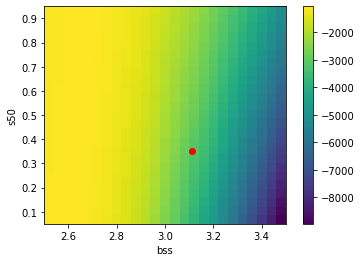

In [ ]:
loglik_arr = np.empty((25,25))

for ind_bss, bss in enumerate(np.linspace(2.5, 3.5, 25)):
    for ind_s50, s50 in enumerate(np.linspace(5, 95, 25)):
        loglik_arr[ind_bss, ind_s50] = roche_inference.return_loglikelihood(times, [1/7, 0.228, 0.927, bss, 1, s50])

plt.imshow(loglik_arr, cmap='viridis', extent=[2.5,3.5,0.05,0.95])
plt.axis()
# plt.plot(loglik_arr)

plt.colorbar()
plt.scatter(3.11, .353, c='r')
plt.xlabel('bss')
plt.ylabel('s50')
plt.show()

## Log-likelihood for beta_max

Text(0, 0.5, 'log likelihood')

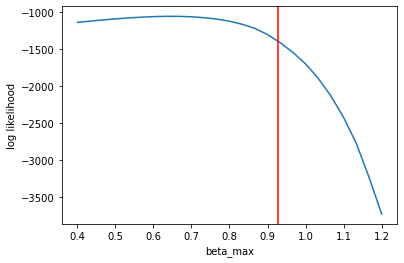

In [ ]:
loglik_arr = np.empty(25)

for ind_beta_max, beta_max in enumerate(np.linspace(0.4, 1.2, 25)):
    loglik_arr[ind_beta_max] = roche_inference.return_loglikelihood(times, [1/7, 0.228, beta_max, 3.11, 1, 35.3])

plt.plot(np.linspace(0.4,1.2, 25), loglik_arr)

plt.axvline(x=0.927, c='r')
plt.xlabel('beta_max')
plt.ylabel('log likelihood')

## Log-likelihood for beta_min

In [17]:
loglik_arr = np.empty(25)

for ind_beta_min, beta_min in enumerate(np.linspace(0.2, 0.9, 25)):
    loglik_arr[ind_beta_min] = roche_inference.return_loglikelihood(times, [1/7, beta_min, 0.927, 3.11, 1, 35.3])

plt.plot(np.linspace(0.2,0.9, 25), loglik_arr)

plt.axvline(x=0.228, c='r')
plt.xlabel('beta_min')
plt.ylabel('log likelihood')

IndexError: list index out of range

## Log-likelihood for bss

Text(0, 0.5, 'log likelihood')

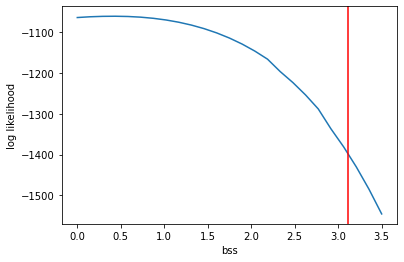

In [ ]:
loglik_arr = np.empty(25)

for ind_bss, bss in enumerate(np.linspace(0, 3.5, 25)):
    loglik_arr[ind_bss] = roche_inference.return_loglikelihood(times, [1/7, 0.228, 0.927, bss, 1, 35.3])

plt.plot(np.linspace(0,3.5, 25), loglik_arr)

plt.axvline(x=3.11, c='r')
plt.xlabel('bss')
plt.ylabel('log likelihood')

## Log-likelihood for s50

Text(0, 0.5, 'log likelihood')

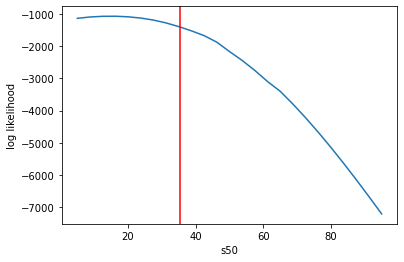

In [ ]:
loglik_arr = np.empty(25)

for ind_s50, s50 in enumerate(np.linspace(5, 95, 25)):
    loglik_arr[ind_s50] = roche_inference.return_loglikelihood(times, [1/7, 0.228, 0.927, 3.11, 1, s50])

plt.plot(np.linspace(5, 95, 25), loglik_arr)

plt.axvline(x=35.5, c='r')
plt.xlabel('s50')
plt.ylabel('log likelihood')

## Log-likelihood for Initial Pss

In [ ]:
loglik_arr = np.empty(25)

for ind_initial_pss, initial_pss in enumerate(np.linspace(0, 1, 25)):
    loglik_arr[ind_initial_pss] = roche_inference.return_loglikelihood(times, [initial_pss, 0.228, 0.927, 3.11, 1, 35.5])

plt.plot(np.linspace(0, 1, 25), loglik_arr)

plt.axvline(x=1/7, c='r')
plt.xlabel('initial_pss')
plt.ylabel('log likelihood')

IndexError: list index out of range

Text(0, 0.5, 'log likelihood')

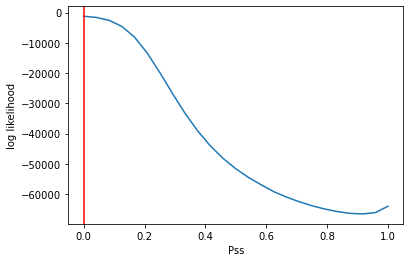

In [ ]:
loglik_arr = np.empty(25)

for ind_pss, pss in enumerate(np.linspace(0, 1, 25)):
    loglik_arr[ind_pss] = roche_inference.return_loglikelihood(times, list(deepflatten([1/7, np.ones(len(age_groups)), pss, np.zeros(len(age_groups)), 0.927, 1, 35.5])))

plt.plot(np.linspace(0, 1, 25), loglik_arr)

plt.axvline(x=0, c='r')
plt.xlabel('Pss')
plt.ylabel('log likelihood')

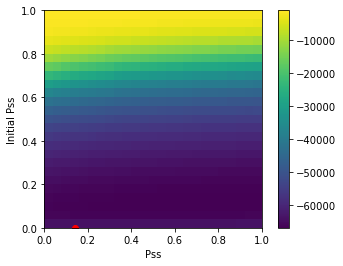

In [ ]:
loglik_arr = np.empty((25,25))

for ind_pss, pss in enumerate(np.linspace(0, 1, 25)):
    for ind_initial_pss, initial_pss in enumerate(np.linspace(0, 1, 25)):
        loglik_arr[ind_pss, ind_initial_pss] = roche_inference.return_loglikelihood(times, list(deepflatten([initial_pss, np.ones(len(age_groups)), pss, np.zeros(len(age_groups)), 0.927, 1, 35.5])))

plt.imshow(loglik_arr, cmap='viridis', extent=[0, 1, 0, 1])
plt.axis()
# plt.plot(loglik_arr)

plt.colorbar()
plt.scatter(1/7, 0, c='r')
plt.xlabel('Pss')
plt.ylabel('Initial Pss')
plt.show()